# **第5章：回帰・分類モデルの構築**
ここでは統計学や機械学習などで非常に広く用いられている**回帰・分類モデル**を解説し，PyMC3で実装してみます．

回帰・分類モデルは**教師あり学習**とも呼ばれています．

回帰モデルは，入力データ$x$から連続値$y \in \mathbb{R}$や自然数$y \in 0,1,2,\ldots$を予測するモデルです．

分類モデルは，入力データ$x$から有限数のラベル$y \in \{1,2,3,\ldots, M \}$を予測するモデルです．$M=2$の場合は，2値分類あるいは識別と呼ばれています．

In [1]:
import pymc3 as pm
import time
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv

## **5.1 【回帰問題】学生の勉強時間$x$からテストの得点$y$を予測する**
ここでは，仮想的に作ったデータセットを利用して，ベイズ統計における回帰モデルの構築方法について学んでみましょう．

～ストーリー～

>ある学校で，学生20人に対して，テスト前の勉強時間と実際にテストで取った点数との関係性を調査しました．
勉強時間（分）を$x \in \{0,1,2,\ldots \}$，テストの得点を$y \in \{0, 1, 2, \ldots, 100\}$とし，$x$から$y$を予測するモデルを構築し，テストで十分な点を獲得するための勉強時間に関して示唆出しを行いたいとします．


In [2]:
# データの読み込みと可視化
url = 'https://drive.google.com/uc?id=12lCoeQCM_zNP5-IVibG34npLCHbKWFrd'
data = read_csv(url, header=None, names=['X', 'Y'])
data

,X,Y
0,507,90.0
1,608,70.0
2,452,80.0
3,368,70.0
4,242,35.0
5,928,100.0
6,262,15.0
7,809,100.0
8,318,15.0
9,49,0.0


Text(0, 0.5, 'y')

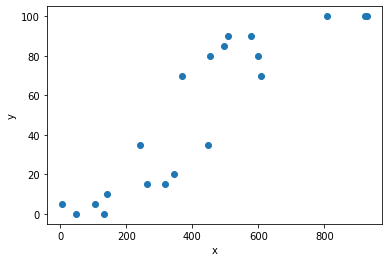

In [3]:
# 扱いやすいようにnumpyに変換
X = np.array(data['X'])
Y = np.array(data['Y'])

# 散布図
plt.scatter(X, Y)
plt.xlabel('x')
plt.ylabel('y')

データからわかること
- 勉強時間にほぼ比例して得点が上がっている．
- 得点はかなりノイジーで，特に300分～600分くらいの時間では得点にかなりのばらつきがある

## **5.2 線形回帰モデルによる予測**

～ストーリー～

>勉強時間$x$から得点$y$を予測するために，最も基本的なモデルである**線形回帰（linear regression）**を使用してみることにしました．

線形回帰のモデルは一般に次のように書けます．
$$
y \approx a \phi(x) + b
$$
ここで$\phi$は**基底関数（basis function）**と呼ばれるものです．ここでは，最も単純な「直線のあてはめ」を行うことにします．すなわち，基底関数を$\phi(x)=x$とします．

線形回帰を確率モデルで記述してみましょう．
このモデルのパラメータは傾き$a$，切片$b$の2つです．
**ベイズ統計では，推定したいパラメータには事前分布を設定する必要があります**．
ここでは，次のようなガウス分布にしたがって2つのパラメータが決定されているとします．
$$
{\rm Normal}(a|0, 10.0) \\
{\rm Normal}(b|0, 10.0)
$$
さらに，各目標変数$y_1, y_2, \ldots, y_N$は次のような線形モデルによって生成されます．
$$
{\rm Normal}(y_i|ax_i+b, 10.0)
$$
これで線形回帰の確率モデルが構成できました．
次に，実際にPyMC3を使ってこのモデルを実装し，挙動を確認してみましょう．

In [14]:
with pm.Model() as model_linear:
  #hyper parameters
  mu_a = 7.0
  sd_a = 10.0
  mu_b = 0.0
  sd_b = 4.0
  sd_y = 100.0
  
  pm_a = pm.Normal('pm_a', mu=mu_a, sd=sd_a) #回帰係数
  pm_b = pm.Normal('pm_b', mu=mu_b, sd=sd_b) #回帰切片
  pm_Y = pm.Normal('pm_Y', mu=pm_a * X + pm_b, sd=sd_y, observed=Y)

#### **モデルの事前チェック**
実際にデータを学習させる前に，作ったモデルから関数を100個ほどサンプルしてみます．
これを行うことによって，作ったモデルがどのような関数を予測のために利用するのかを視覚的に確認することができます．

Text(0.5, 1.0, 'prior predictive with Y')

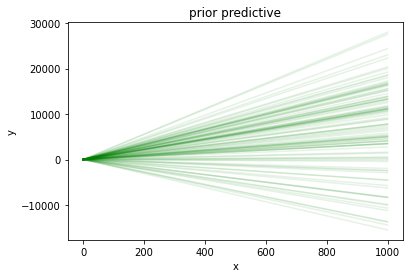

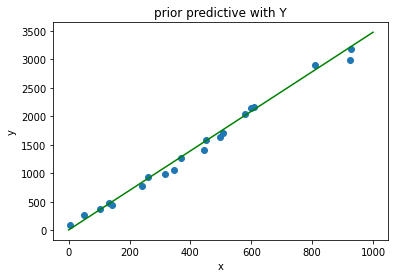

In [15]:
# 関数pm.sample_prior_predictive()を利用して，モデルから関数の例をサンプルしてみる
with model_linear:
  N_prior = 100
  prior_samples = pm.sample_prior_predictive(N_prior)

# 関数の分布を可視化してみる
plt.figure()
X_range = np.linspace(0,1000, 1000)
for i in range(N_prior):
    plt.plot(X_range, [prior_samples['pm_a'][i]*x + prior_samples['pm_b'][i] for x in X_range], 'g-', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('prior predictive')

# ある1つの関数のサンプルを取り出し，さらに対応するデータYの分布をチェックする
plt.figure()
plt.plot(X_range, [prior_samples['pm_a'][0]*x + prior_samples['pm_b'][0] for x in X_range], 'g-')
plt.scatter(X, prior_samples['pm_Y'][0])
plt.xlabel('x')
plt.ylabel('y')
plt.title('prior predictive with Y')


#### **5.2.1 やってみよう（5分）**
- 事前分布のパラメータ（mu_a, sd_a, mu_b, sd_b, sd_y）を変更して，関数の分布がどのように変化するのか見てみましょう．それぞれ5つのパラメータはどのような意味を持ちますか？
- データの傾向（$x$は0～1000，$y$は0～100）を考慮すると，どのような事前分布が適切なのか考えてみましょう．$\dagger$

#### **データの学習**
構築したモデルに対して，実際に学習データを与えてみましょう．
```pm.sample```を使うことにより，事後分布からの$a$および$b$のサンプルを複数得ることができます．
これらを使って，予測分布をプロットしてみましょう．

In [16]:
# MCMCによる推論計算
with model_linear:
  N_posterior = 1000
  start = time.time()
  trace = pm.sample(N_posterior, step=pm.SMC(), chains=1)
  print('elapsed time: {:.9f} [sec]'.format(time.time() - start))
  print('log marginal likelihood : ' + str(np.log(model_linear.marginal_likelihood))) #周辺尤度を指数化したもの（大きいほど当てはまりがよいという指標の一種）


Sample initial stage: ...
Stage: 0 Beta: 0.000 Steps: 25
100%|██████████| 1000/1000 [00:01<00:00, 679.80it/s]
Stage: 1 Beta: 0.001 Steps: 6
100%|██████████| 1000/1000 [00:00<00:00, 3288.86it/s]
Stage: 2 Beta: 0.006 Steps: 3
100%|██████████| 1000/1000 [00:00<00:00, 5307.86it/s]
Stage: 3 Beta: 0.046 Steps: 5
100%|██████████| 1000/1000 [00:00<00:00, 2810.78it/s]
Stage: 4 Beta: 0.357 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 4497.68it/s]
Stage: 5 Beta: 1.000 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 3965.59it/s]

elapsed time: 3.430002213 [sec]
log marginal likelihood : -116.24499202289576


Text(0.5, 1.0, 'linear regression')

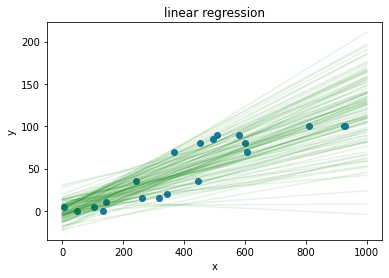

In [8]:
# posterior predictive check
plt.figure()
for i in range(0, len(trace), 10):
    plt.plot(X_range, [trace['pm_a'][i] * x + trace['pm_b'][i] for x in X_range], 'g-', alpha=0.1)

plt.scatter(X, Y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('linear regression')


In [17]:
pm.summary(trace) #回帰係数をT検定した値とほぼ同じ

,mean,sd,mc_error,hpd_2.5,hpd_97.5
pm_a,0.122360,0.044094,0.001346,0.037940,0.204002
pm_b,0.062826,3.852465,0.122835,-7.544522,7.253470


#### **5.2.2 やってみよう（5分）**
- 事前分布のパラメータ（mu_a, sd_a, mu_b, sd_b, sd_y）を変更して，予測分布がどのように変化するか観察してみましょう．
- ```pm.sample()```を実行した後に出力されるlog marginal likelihood : -116.2404294815411のような値は，「モデルのデータに対する当てはまり具合」を表しています．事前分布のパラメータを変更して，当てはまり具合の値を調べてみましょう．（一番高い値を出した人が優勝です．ただしい```N_sample=1000```は固定で．）

## **5.3 ダミー変数の追加**

～ストーリー～

>線形回帰モデルを使って，学生の勉強時間からテストの点数を大まかに予測するモデルができました．
調査を進めると，実は学生の中にはテストで点を取るための「特別な指導」を受けた学生とそうでない学生が混ざっていることがわかりました．「特別な指導」を受けたことによる効果をモデルに導入できれば，予測精度が改善する可能性があります．
ここでは，説明変数として各学生の勉強時間$x$だけではなく，「特別な指導」を受けたかどうかを表す説明変数$z$も利用して，予測モデルの改善を目指しましょう．

In [18]:
# zが入った新しいデータを読み込む．
url = 'https://drive.google.com/uc?id=1eUvJ0B7pEYPbctHrK3B0u3DflOMAPVZf'
data = read_csv(url, header=None, names=['X', 'Y', 'Z'])
data

,X,Y,Z
0,507,90.0,1
1,608,70.0,0
2,452,80.0,1
3,368,70.0,1
4,242,35.0,1
5,928,100.0,0
6,262,15.0,0
7,809,100.0,1
8,318,15.0,0
9,49,0.0,1


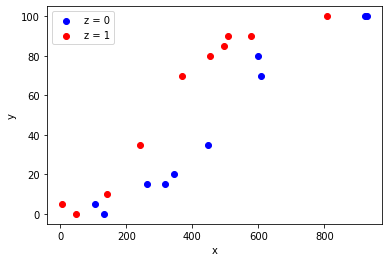

In [19]:
X = np.array(data['X'])
Y = np.array(data['Y'])

# z = 0 （指導なし）
# z = 1 （指導あり）
Z = np.array(data['Z'])

# 指導あり/なしで色分けして散布図を描く
plt.scatter(X[Z==0], Y[Z==0], color='b', label='z = 0')
plt.scatter(X[Z==1], Y[Z==1], color='r', label='z = 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

グラフを見ると，特別指導を受けている学生と受けていない学生とで，データの傾向に違いがあることがわかります．
特別指導を受けている学生の方が得点の立ち上がりが早く，少ない勉強時間で高得点に到達できていることがわかります．

そこで，これらの違いを考慮するため，「特別指導を受けている場合と受けていない場合とで，直線の切片が異なる」という仮定を置いてモデルを改善することにします．
具体的には，次のような確率モデルにします．
$$
{\rm Normal}(a|0, 10.0) \\
{\rm Normal}(b_1|0, 10.0) \\
{\rm Normal}(b_2|0, 10.0) \\
{\rm Normal}(y_i|ax_i+{\bf b}^{\rm T} {\bf z}_i, 10.0)
$$
ここで${\bf b} = (b_1, b_2)^{\rm T}$です．
${\bf z}_n$は，$n$番目のデータが特別指導を受けたか否かを示す変数（ベクトル）です．例えば，
${\bf z}_n = (1, 0)^{\rm T}$のときは特別指導なし，${\bf z}_n = (0, 1)^{\rm T}$のときは特別指導ありという風に決めます．こうすることによって，
特別指導のない場合は切片が${\bf b}^{\rm T} {\bf z}_n = b_1$，ある場合は${\bf b}^{\rm T} {\bf z}_n = b_2$となり，切片を切り替えることができるようになります．
このような$z$の表現方法をone-hot表現と呼びます．

一方で，傾き$a$に関しては今回は同一としています．


In [20]:
# データをone-hot表現に変換しておく．
Z_onehot = np.identity(2)[Z]
Z_onehot

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [21]:
with pm.Model() as model_dammy:
  # ハイパーパラメータの設定
  mu_a = 0.0
  sd_a = 10.0
  mu_b = 0.0
  sd_b = 10.0
  sd_y = 10.0

  # 傾き，切片の事前分布
  pm_a = pm.Normal('pm_a', mu=mu_a, sd=sd_a)
  pm_b = pm.Normal('pm_b', mu=mu_b, sd=sd_b, shape=2) #shapeはベクトル、スカラー、行列で返すことができる。shape=2は2変数を返す意味。

  # 観測データ（得点）の分布
  pm_Y = pm.Normal('pm_Y', mu=pm_a * X + pm.math.dot(pm_b, Z_onehot.T), sd=sd_y, observed=Y)



WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Text(0.5, 1.0, 'prior predictive')

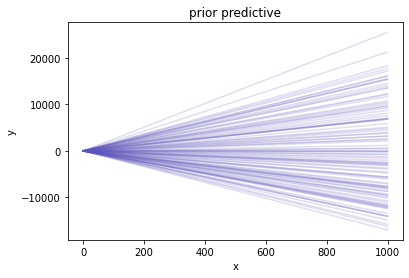

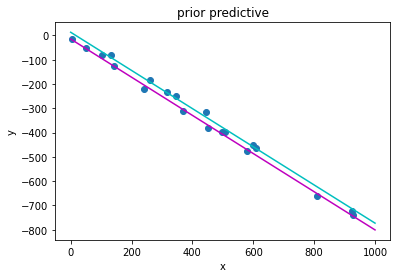

In [22]:
# モデルから関数をシミュレートしてみる
with model_dammy:
  N_prior = 100
  prior_samples = pm.sample_prior_predictive(N_prior)

# 関数の分布の可視化
plt.figure()
for i in range(N_prior):
  plt.plot(X_range, [prior_samples['pm_a'][i] * x + prior_samples['pm_b'][i][0] for x in X_range], color='c', alpha=0.1)
  plt.plot(X_range, [prior_samples['pm_a'][i] * x + prior_samples['pm_b'][i][1] for x in X_range], color='m', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('prior predictive')

# １つの関数と対応するデータの可視化
plt.figure()
plt.plot(X_range, [prior_samples['pm_a'][0] * x + prior_samples['pm_b'][0][0] for x in X_range], color='c')
plt.plot(X_range, [prior_samples['pm_a'][0] * x + prior_samples['pm_b'][0][1] for x in X_range], color='m')
plt.scatter(X, prior_samples['pm_Y'][0])
plt.xlabel('x')
plt.ylabel('y')
plt.title('prior predictive')


In [23]:
# MCMCによる推論計算
with model_dammy:
    start = time.time()
    trace = pm.sample(1000, step=pm.SMC(), chains=1)
    print('')
    print('elapsed time: {:.9f} [sec]'.format(time.time() - start))
    print('log marginal likelihood : ' + str(np.log(model_dammy.marginal_likelihood)))

Sample initial stage: ...
Stage: 0 Beta: 0.000 Steps: 25
100%|██████████| 1000/1000 [00:01<00:00, 832.76it/s]
Stage: 1 Beta: 0.000 Steps: 8
100%|██████████| 1000/1000 [00:00<00:00, 2488.65it/s]
Stage: 2 Beta: 0.000 Steps: 3
100%|██████████| 1000/1000 [00:00<00:00, 5913.78it/s]
Stage: 3 Beta: 0.001 Steps: 6
100%|██████████| 1000/1000 [00:00<00:00, 3451.92it/s]
Stage: 4 Beta: 0.004 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 4705.75it/s]
Stage: 5 Beta: 0.026 Steps: 5
100%|██████████| 1000/1000 [00:00<00:00, 4134.88it/s]
Stage: 6 Beta: 0.093 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 4831.59it/s]
Stage: 7 Beta: 0.253 Steps: 5
100%|██████████| 1000/1000 [00:00<00:00, 4174.39it/s]
Stage: 8 Beta: 0.650 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 4767.80it/s]
Stage: 9 Beta: 1.000 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 4708.49it/s]


elapsed time: 6.828034878 [sec]
log marginal likelihood : -86.48422838090414


Text(0.5, 1.0, 'linear regression with dammy variables')

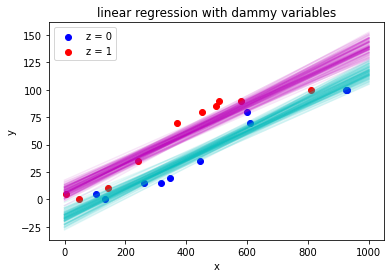

In [24]:
# 予測分布を可視化する

plt.figure()
for i in range(0, len(trace), 10):
    plt.plot(X_range, [trace['pm_a'][i] * x + trace['pm_b'][i][0] for x in X_range], color='c', alpha=0.1)
    plt.plot(X_range, [trace['pm_a'][i] * x + trace['pm_b'][i][1] for x in X_range], color='m', alpha=0.1)
plt.scatter(X[Z==0], Y[Z==0], color='b', label='z = 0')
plt.scatter(X[Z==1], Y[Z==1], color='r', label='z = 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('linear regression with dammy variables')


#### **やってみよう**
上記の「ダミー変数を用いた直線回帰」で，モデルとしてまだ不十分な点を指摘してみましょう．

（ヒント：不自然な点やまだ表現しきれていないデータの特徴などは？）



## **5.4 ロジスティック回帰モデル**

～ストーリー～

>特別指導の有無をダミー変数として導入することにより，予測モデルを改善することができました．
しかし，モデルにはまだいくつかの問題点が残っています．
第１に，得点$y$の値域の問題があります．単純な直線の関数を利用しているために，予測値$y$の取りうる値がおかしくなっており，実際に100点を超えるものや，マイナスになってしまっている予測値が見られます．
第２に，単純な直線の関数ではデータの傾向をうまく補足しきれていないように見られます．勉強時間に対するテストの得点の上昇傾向として，最初は傾きが緩やかで，途中で急上昇し，最後には再び緩やかになる傾向が見られます．これらの傾向をうまく捉えられるようにモデルを改善できないでしょうか．


ここではこれらの問題を同時に解決するために，**シグモイド関数（sigmoid function）**と**二項分布（Binomial distribution）**を使った**ロジスティック回帰（logistic regression）**を導入します．

まず，$y$の値域に関する問題点を解決してみましょう．
ここでは「1問5点の問題が20問あり，各学生に関して1問当たりの正解確率$\mu \in (0, 1)$によって最終的な得点が決まる」とざっくり仮定してみましょう．これは正解数を$y'$とすると次のような二項分布を使って表せます．
$$
{\rm Binomial}(y'|\mu, 20) \\
y = 5y'
$$
次に，得点の上昇傾向に関する仮説をモデルに導入しましょう．
これはシグモイド関数を用いることによって実現できます．

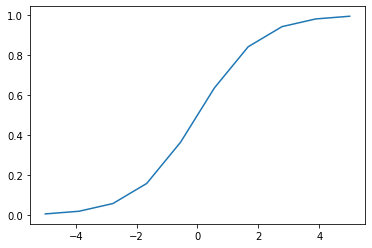

In [25]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

plt.plot(np.linspace(-5,5,10), sigmoid(np.linspace(-5,5,10)))

上図のように，シグモイド関数は実数全体の入力値を0から1までの実数値に押し込めて出力させることができます．
したがって，シグモイド関数の出力値を二項分布のパラメータ$\mu \in (0, 1)$として使うことができます．

以上を確率モデルとして書き直すと次のようになります．

$$
{\rm Normal}(a|0, 0.01) \\
{\rm Normal}(b_1|0, 10.0) \\
{\rm Normal}(b_2|0, 10.0) \\
\mu_i = {\rm Sigmoid}(a x_i+{\bf b}^{\rm T} {\bf z}_i) \\
{\rm Binomial}(y'_i|20, \mu_i) \\
y_i = 5y'_i
$$


In [27]:
# モデル設計
with pm.Model() as model_logistic:
  # テストの問題は20問とする
  M = 20

  # 事前分布
  pm_a = pm.Normal('pm_a', mu=0, sd=0.01)
  pm_b = pm.Normal('pm_b', mu=-5, sd=10.0, shape=2)

  # 線形回帰の出力にシグモイド関数を被せることにより，確率値(0,1)に変換
  pm_mu = pm.Deterministic('pm_mu', sigmoid(pm_a * X + pm.math.dot(pm_b, Z_onehot.T)))

  # テストの正解数y'は二項分布に従う．
  # 得点を5で割った正解数を観測データとする．
  pm_Y_dash = pm.Binomial('pm_Y_dash', n=M, p=pm_mu, observed=Y/5)


Text(0.5, 1.0, 'prior predictive check')

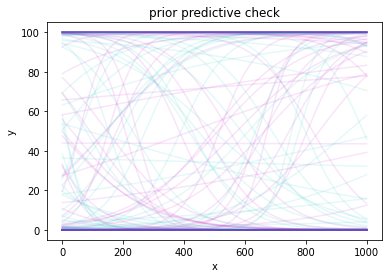

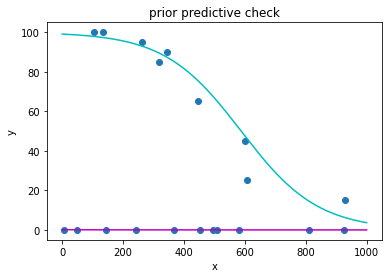

In [28]:
# モデルから関数をシミュレートしてみる
with model_logistic:
  N_prior = 100
  prior_samples = pm.sample_prior_predictive(N_prior)

# 関数の分布を可視化
plt.figure()
for i in range(N_prior):
  plt.plot(X_range, [5*M*sigmoid(prior_samples['pm_a'][i] * x + prior_samples['pm_b'][i][0]) for x in X_range], color='c', alpha=0.1)
  plt.plot(X_range, [5*M*sigmoid(prior_samples['pm_a'][i] * x + prior_samples['pm_b'][i][1]) for x in X_range], color='m', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('prior predictive check')

# １つの関数と対応するデータを可視化
plt.figure()
plt.plot(X_range, [5*M*sigmoid(prior_samples['pm_a'][0] * x + prior_samples['pm_b'][0][0]) for x in X_range], color='c')
plt.plot(X_range, [5*M*sigmoid(prior_samples['pm_a'][0] * x + prior_samples['pm_b'][0][1]) for x in X_range], color='m')
plt.scatter(X, 5*prior_samples['pm_Y_dash'][0])
plt.xlabel('x')
plt.ylabel('y')
plt.title('prior predictive check')


In [29]:
# MCMCによる推論計算
with model_logistic:
  start = time.time()
  trace = pm.sample(1000, step=pm.SMC(), random_seed=1)
  print('elapsed time: {:.9f} [sec]'.format(time.time() - start))
  print('log marginal likelihood : ' + str(np.log(model_logistic.marginal_likelihood)))


Sample initial stage: ...
Stage: 0 Beta: 0.001 Steps: 25
100%|██████████| 1000/1000 [00:01<00:00, 807.48it/s]
Stage: 1 Beta: 0.004 Steps: 8
100%|██████████| 1000/1000 [00:00<00:00, 2360.35it/s]
Stage: 2 Beta: 0.010 Steps: 3
100%|██████████| 1000/1000 [00:00<00:00, 6008.70it/s]
Stage: 3 Beta: 0.031 Steps: 6
100%|██████████| 1000/1000 [00:00<00:00, 3196.91it/s]
Stage: 4 Beta: 0.085 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 4521.75it/s]
Stage: 5 Beta: 0.227 Steps: 5
100%|██████████| 1000/1000 [00:00<00:00, 3762.36it/s]
Stage: 6 Beta: 0.577 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 4861.02it/s]
Stage: 7 Beta: 1.000 Steps: 5
100%|██████████| 1000/1000 [00:00<00:00, 3865.01it/s]


elapsed time: 7.501149893 [sec]
log marginal likelihood : -36.088847365980456


Text(0.5, 1.0, 'posterior predictive check')

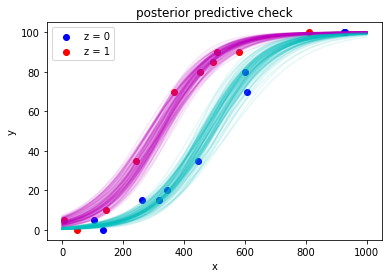

In [30]:
# 予測分布を可視化する

plt.figure()
for i in range(0, len(trace), 10):
    plt.plot(X_range, [5*M*sigmoid(trace['pm_a'][i] * x + trace['pm_b'][i][0]) for x in X_range], color='c', alpha=0.1)
    plt.plot(X_range, [5*M*sigmoid(trace['pm_a'][i] * x + trace['pm_b'][i][1]) for x in X_range], color='m', alpha=0.1)
plt.scatter(X[Z==0], Y[Z==0], color='b', label='z = 0')
plt.scatter(X[Z==1], Y[Z==1], color='r', label='z = 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('posterior predictive check')



## **5.4 潜在変数モデル（観測できないものを作ってしまう）**

～ストーリー～

>特別指導に関するダミー変数の導入と，シグモイド関数を使ったロジスティック回帰モデルを用いることによって，予測モデルはかなり改善してきました．
この成功を機に，別のテスト科目のデータに対してモデルを横展開することにしました．
しかし，新しい科目のデータを手に入れたところ，以前は予測に有用だった「特別指導の有無」に関するデータが保存されていないことがわかりました．「特別指導の有無」の情報は今回は使うことができないのでしょうか？

#### **モデル**

ここでは潜在変数モデルを用いることによって，直接観測されていない「特別指導の有無」自体もモデルの中で推定してしまう方法を設計したいと思います．
確率モデルは実質的には先ほどのロジスティック回帰と同じです．
$$
{\rm Normal}(a|0, 0.01) \\
{\rm Normal}(b_1|0, 10.0) \\
{\rm Normal}(b_2|0, 10.0) \\
\mu_i = {\rm Sigmoid}(a x_i+{\bf b}^{\rm T} {\bf z}_i) \\
{\rm Binomial}(y'_i|20, \mu_i) \\
y_i = 5y'_i
$$
重要な点は，今回は${\bf z}_i$が**データとして観測されていない**ということです．ベイズ統計では，観測されていない値やパラメータには事前分布を設定することによって推論を行います．ここでは，各${\bf z}_i$に次のようなカテゴリ分布（またはベルヌーイ分布）を設定します．
$$
{\rm Categorical}(z_i|(0.5, 0.5))
$$
ここでは，特別指導を受けた学生は全体の半々程度であるとの仮定を置き，パラメータを$(0.5, 0.5)$としました．
このような観測されていない変数$z_1, z_2, \ldots, z_N$のことを**潜在変数（latent variable）**あるいは**隠れ変数（hidden variable）**と呼びます．
ベイズ統計では，潜在変数を駆使することで非常に柔軟性が高く，多様なモデルを設計できるようになります．

In [31]:
# データの読み込み

url = 'https://drive.google.com/uc?id=1sojn5GRd37WYyCfJuXfUmJotKsgzqhPN'
data = read_csv(url, header=None, names=['X', 'Y'])
data

,X,Y
0,608.0,90.0
1,730.0,70.0
2,542.0,80.0
3,442.0,70.0
4,291.0,35.0
5,921.0,90.0
6,314.0,15.0
7,700.0,80.0
8,381.0,15.0
9,59.0,0.0


Text(0, 0.5, 'y')

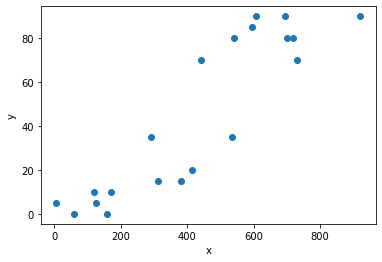

In [32]:
# 可視化
X = np.array(data['X'])
Y = np.array(data['Y'])

plt.scatter(X, Y)
plt.xlabel('x')
plt.ylabel('y')

In [33]:

# モデル設計
with pm.Model() as model_latent:
  # データ数（学生数）
  N = X.shape[0]
  
  # 問題数
  M = 20

  # 事前分布
  pm_a = pm.Normal('pm_a', mu=0, sd=0.01)
  pm_b = pm.Normal('pm_b', mu=0, sd=10.0, shape=2)

  # 潜在変数（特別指導の有無は半々程度と仮定）
  pm_Z = pm.Categorical('pm_Z', p=[0.5, 0.5], shape=N)
  pm_Y_dash = pm.Binomial('pm_Y_dash', n=M, p=sigmoid(pm_a * X + pm_b[pm_Z]), observed=Y/5)



Text(0.5, 1.0, 'Z')

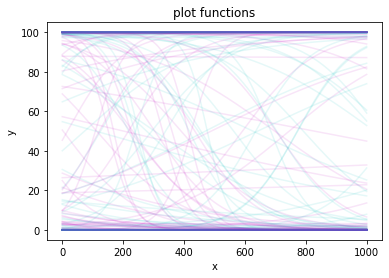

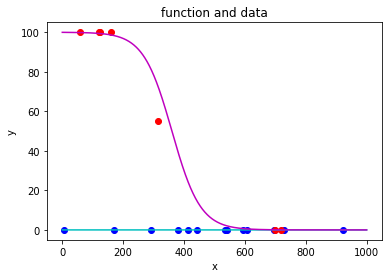

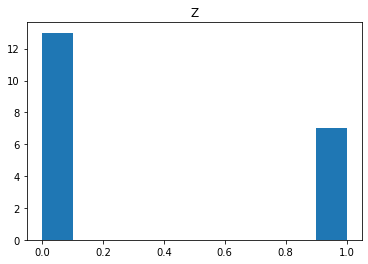

In [34]:
# モデルから関数をシミュレートしてみる

with model_latent:
  prior_samples = pm.sample_prior_predictive(N_prior)

# 関数の分布の可視化
plt.figure()
for i in range(N_prior):
    plt.plot(X_range, [5*M*sigmoid(prior_samples['pm_a'][i] * x + prior_samples['pm_b'][i][0]) for x in X_range], color='c', alpha=0.1)
    plt.plot(X_range, [5*M*sigmoid(prior_samples['pm_a'][i] * x + prior_samples['pm_b'][i][1]) for x in X_range], color='m', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('plot functions')

# １つの関数とそれに対応するデータの可視化
plt.figure()
plt.plot(X_range, [5*M*sigmoid(prior_samples['pm_a'][0] * x + prior_samples['pm_b'][0][0]) for x in X_range], color='c')
plt.plot(X_range, [5*M*sigmoid(prior_samples['pm_a'][0] * x + prior_samples['pm_b'][0][1]) for x in X_range], color='m')
plt.scatter(X[prior_samples['pm_Z'][0]==0], 5*prior_samples['pm_Y_dash'][0][prior_samples['pm_Z'][0]==0], color='b', label='z = 0')
plt.scatter(X[prior_samples['pm_Z'][0]==1], 5*prior_samples['pm_Y_dash'][0][prior_samples['pm_Z'][0]==1], color='r', label='z = 0')

plt.xlabel('x')
plt.ylabel('y')
plt.title('function and data')

# 潜在変数zのヒストグラム
plt.figure()
plt.hist(prior_samples['pm_Z'][0])
plt.title('Z')

In [35]:
# MCMCによる推論計算
with model_latent:
  start = time.time()
  trace = pm.sample(1000, chains=1)
  print('elapsed time: {:.9f} [sec]'.format(time.time() - start))


Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [pm_b, pm_a]
>BinaryGibbsMetropolis: [pm_Z]
100%|██████████| 1500/1500 [00:06<00:00, 246.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


elapsed time: 40.859327078 [sec]


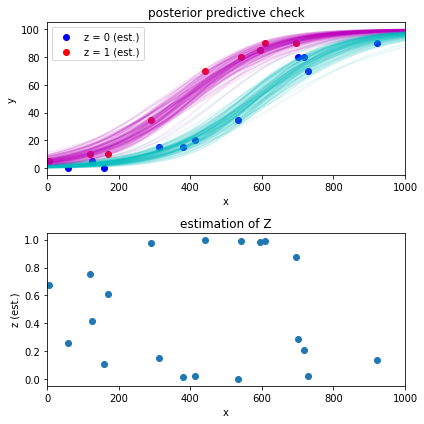

In [36]:

# Zの推定結果の期待値を計算
Z_est = np.mean(trace['pm_Z'], axis=0)

plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
# 予測分布の可視化
for i in range(0, len(trace), 10):
    plt.plot(X_range, [5*M*sigmoid(trace['pm_a'][i] * x + trace['pm_b'][i][0]) for x in X_range], color='c', alpha=0.1)
    plt.plot(X_range, [5*M*sigmoid(trace['pm_a'][i] * x + trace['pm_b'][i][1]) for x in X_range], color='m', alpha=0.1)
plt.scatter(X[Z_est<0.5], Y[Z_est<0.5], color='b', label='z = 0 (est.)')
plt.scatter(X[Z_est>=0.5], Y[Z_est>=0.5], color='r', label='z = 1 (est.)')
plt.xlim([X_range[0], X_range[-1]])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('posterior predictive check')

plt.subplot(2,1,2)
# 各学生ごとのZの推定値も併せてプロットしてみる
plt.scatter(X, Z_est)
plt.xlim([X_range[0], X_range[-1]])
plt.xlabel('x')
plt.ylabel('z (est.)')
plt.title('estimation of Z')
plt.tight_layout()